Week_2 Day_3

In [1]:
! curl https://download.pytorch.org/tutorial/hymenoptera_data.zip -o hymenoptera_data.zip
! unzip hymenoptera_data.zip


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.0M  100 45.0M    0     0  44.3M      0  0:00:01  0:00:01 --:--:-- 44.3M
Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hym

In [2]:
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch
import os

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f26a8d3b490>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f26a8d3bb10>}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


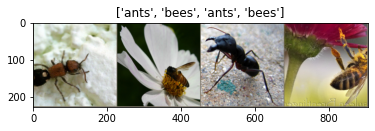

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [6]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Using Resnet18 without pretrained weights

In [9]:
model_ft = models.resnet18(pretrained=None)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=21)

Epoch 0/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7314 Acc: 0.5574
val Loss: 0.8355 Acc: 0.5425

Epoch 1/20
----------
train Loss: 0.7018 Acc: 0.6230
val Loss: 0.7456 Acc: 0.5882

Epoch 2/20
----------
train Loss: 0.6665 Acc: 0.6680
val Loss: 0.7674 Acc: 0.6013

Epoch 3/20
----------
train Loss: 0.7795 Acc: 0.5574
val Loss: 0.7641 Acc: 0.5817

Epoch 4/20
----------
train Loss: 0.6920 Acc: 0.6270
val Loss: 0.6469 Acc: 0.6471

Epoch 5/20
----------
train Loss: 0.7589 Acc: 0.5779
val Loss: 0.6692 Acc: 0.6863

Epoch 6/20
----------
train Loss: 0.6156 Acc: 0.6803
val Loss: 0.6258 Acc: 0.6601

Epoch 7/20
----------
train Loss: 0.6098 Acc: 0.6721
val Loss: 0.5335 Acc: 0.7386

Epoch 8/20
----------
train Loss: 0.6395 Acc: 0.6230
val Loss: 0.5449 Acc: 0.7451

Epoch 9/20
----------
train Loss: 0.5525 Acc: 0.7213
val Loss: 0.5675 Acc: 0.7647

Epoch 10/20
----------
train Loss: 0.5952 Acc: 0.6598
val Loss: 0.5776 Acc: 0.7386

Epoch 11/20
----------
train Loss: 0.5953 Acc: 0.6311
val Loss: 0.5697 Acc: 0.7320

Epoch 12/20
----------
t

loading pretrained weights imagenet with freezing extractor part


In [11]:
model_conv = torchvision.models.resnet18(pretrained='imagenet')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=21)

Epoch 0/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5840 Acc: 0.6762
val Loss: 0.1971 Acc: 0.9412

Epoch 1/20
----------
train Loss: 0.4627 Acc: 0.7951
val Loss: 0.5923 Acc: 0.7059

Epoch 2/20
----------
train Loss: 0.5895 Acc: 0.7254
val Loss: 0.4267 Acc: 0.8431

Epoch 3/20
----------
train Loss: 0.4752 Acc: 0.8156
val Loss: 0.2216 Acc: 0.9085

Epoch 4/20
----------
train Loss: 0.4417 Acc: 0.8238
val Loss: 0.2150 Acc: 0.9346

Epoch 5/20
----------
train Loss: 0.5545 Acc: 0.7910
val Loss: 0.2501 Acc: 0.9150

Epoch 6/20
----------
train Loss: 0.5594 Acc: 0.7623
val Loss: 0.3509 Acc: 0.8693

Epoch 7/20
----------
train Loss: 0.4157 Acc: 0.8361
val Loss: 0.1651 Acc: 0.9608

Epoch 8/20
----------
train Loss: 0.3770 Acc: 0.8279
val Loss: 0.1735 Acc: 0.9608

Epoch 9/20
----------
train Loss: 0.3187 Acc: 0.8607
val Loss: 0.1554 Acc: 0.9542

Epoch 10/20
----------
train Loss: 0.3001 Acc: 0.8730
val Loss: 0.1718 Acc: 0.9542

Epoch 11/20
----------
train Loss: 0.3856 Acc: 0.8115
val Loss: 0.1750 Acc: 0.9477

Epoch 12/20
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


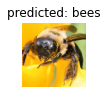

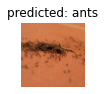

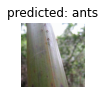

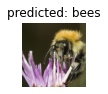

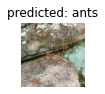

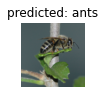

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

With pretrained weights imagenet and unfreeze extractor layers


In [14]:
model_ft = models.resnet18(pretrained='imagenet')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=21)

Epoch 0/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7171 Acc: 0.6885
val Loss: 0.5393 Acc: 0.8366

Epoch 1/20
----------
train Loss: 0.4651 Acc: 0.8238
val Loss: 0.3722 Acc: 0.8431

Epoch 2/20
----------
train Loss: 0.6182 Acc: 0.7664
val Loss: 0.2514 Acc: 0.9150

Epoch 3/20
----------
train Loss: 0.4783 Acc: 0.7787
val Loss: 0.6338 Acc: 0.8301

Epoch 4/20
----------
train Loss: 0.4894 Acc: 0.8033
val Loss: 0.2297 Acc: 0.8954

Epoch 5/20
----------
train Loss: 0.6178 Acc: 0.7828
val Loss: 0.3069 Acc: 0.8758

Epoch 6/20
----------
train Loss: 0.5880 Acc: 0.7992
val Loss: 0.2877 Acc: 0.8889

Epoch 7/20
----------
train Loss: 0.3276 Acc: 0.8607
val Loss: 0.2116 Acc: 0.9216

Epoch 8/20
----------
train Loss: 0.3864 Acc: 0.8402
val Loss: 0.3175 Acc: 0.8758

Epoch 9/20
----------
train Loss: 0.3478 Acc: 0.8484
val Loss: 0.2002 Acc: 0.9216

Epoch 10/20
----------
train Loss: 0.3015 Acc: 0.8893
val Loss: 0.2465 Acc: 0.9020

Epoch 11/20
----------
train Loss: 0.2729 Acc: 0.8730
val Loss: 0.1958 Acc: 0.9346

Epoch 12/20
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


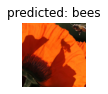

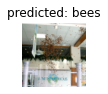

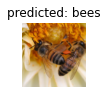

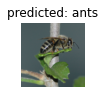

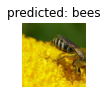

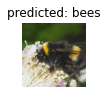

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()